In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from src import generate, train, eval
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import modules.baseline_nn as baseline_nn

import pickle

In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -2.445995590283073 - 2.2643438832509464
In Domain: (-10, 10)
Y-space: -2.292038921098926 - 2.1208595881462915
Out Domain: (-20, 20)
Y-space: -2.2153775188109868 - 2.4024802423086653


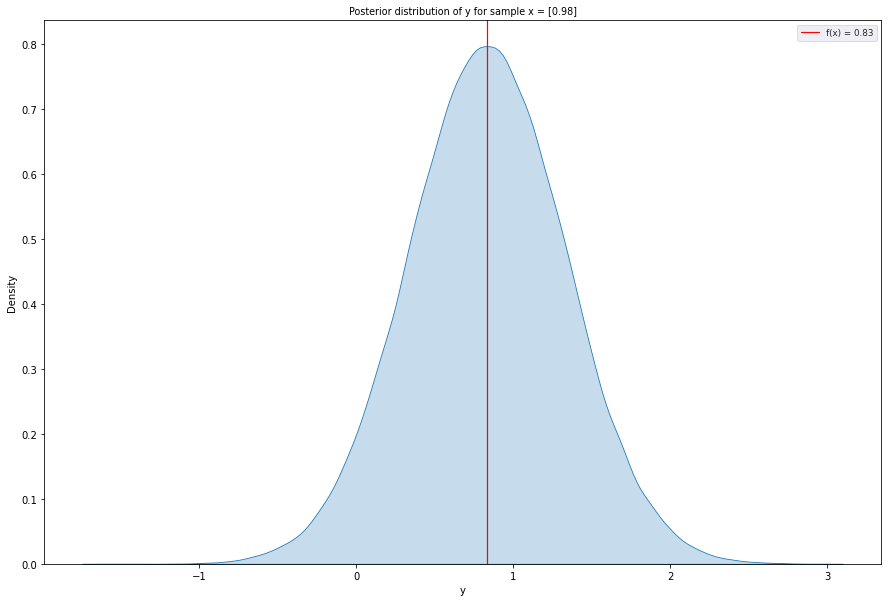

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test, y_test = torch.vstack((x_test_in_domain, x_test_out_domain)), torch.vstack((y_test_in_domain, y_test_out_domain))

In [7]:
x_train.shape, y_train.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [9]:
x, y = next(iter(train_dataloader))

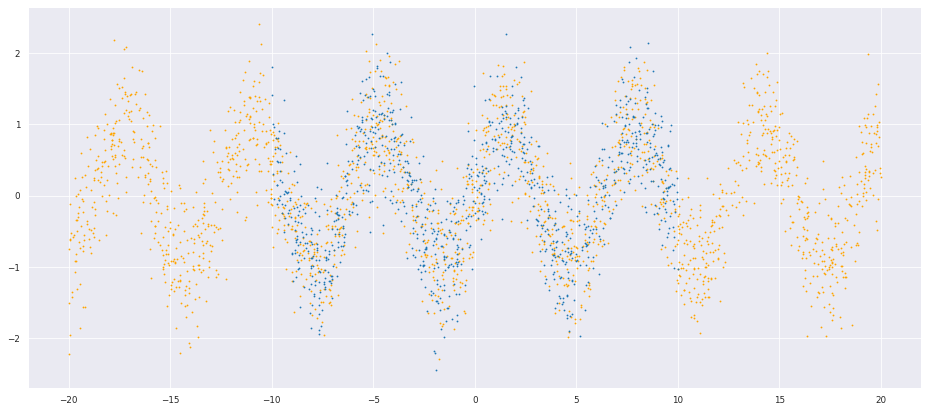

In [10]:

test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)

In [11]:
net = baseline_nn.FFNN(1, 1, hidden_features=[32,32], device="cpu")
basenn = baseline_nn.BaselineNN(net)
basenn

BaselineNN(
  (net): FFNN(
    (fc): Sequential(
      (fc0): Linear(in_features=1, out_features=32, bias=True)
      (act0): ReLU()
      (fc1): Linear(in_features=32, out_features=32, bias=True)
      (act1): ReLU()
      (fc2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [12]:
optim = torch.optim.Adam(basenn.net.parameters(), lr=1e-4)
loss = []
def callback(bnn, i, mse):
    if i % 500 == 0:
        print("epoch: {} | mse: {}".format(i, mse))
    loss.append(mse)
    
basenn.fit(train_dataloader, optim, 20000, callback)

/home/alvar/miniconda3/envs/master/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alvar/miniconda3/envs/master/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([104, 1])) that is different to the input size (torch.Size([104])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 | mse: 1.1199846267700195
epoch: 500 | mse: 0.7017653584480286
epoch: 1000 | mse: 0.70175701379776
epoch: 1500 | mse: 0.7017514109611511
epoch: 2000 | mse: 0.7017479687929153
epoch: 2500 | mse: 0.7017454728484154
epoch: 3000 | mse: 0.7017435729503632
epoch: 3500 | mse: 0.7017417103052139
epoch: 4000 | mse: 0.7017393931746483
epoch: 4500 | mse: 0.7017370983958244
epoch: 5000 | mse: 0.7017351016402245
epoch: 5500 | mse: 0.7017334178090096
epoch: 6000 | mse: 0.7017320990562439
epoch: 6500 | mse: 0.7017306089401245
epoch: 7000 | mse: 0.7017293199896812
epoch: 7500 | mse: 0.7017281576991081
epoch: 8000 | mse: 0.7017270103096962
epoch: 8500 | mse: 0.7017258927226067
epoch: 9000 | mse: 0.7017247974872589
epoch: 9500 | mse: 0.7017235234379768
epoch: 10000 | mse: 0.7017223909497261
epoch: 10500 | mse: 0.7017213851213455
epoch: 11000 | mse: 0.7017204985022545
epoch: 11500 | mse: 0.7017196714878082
epoch: 12000 | mse: 0.7017186209559441
epoch: 12500 | mse: 0.7017176449298859
epoch: 13000

FFNN(
  (fc): Sequential(
    (fc0): Linear(in_features=1, out_features=32, bias=True)
    (act0): ReLU()
    (fc1): Linear(in_features=32, out_features=32, bias=True)
    (act1): ReLU()
    (fc2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [13]:
###

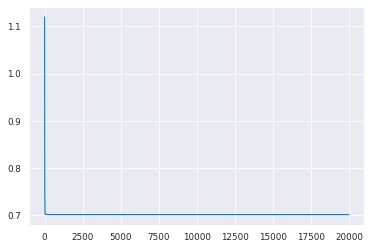

In [14]:
plt.plot(loss)

In [15]:
train_sort = torch.argsort(x_train.squeeze())
preds = basenn.predict(x_train[train_sort], aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

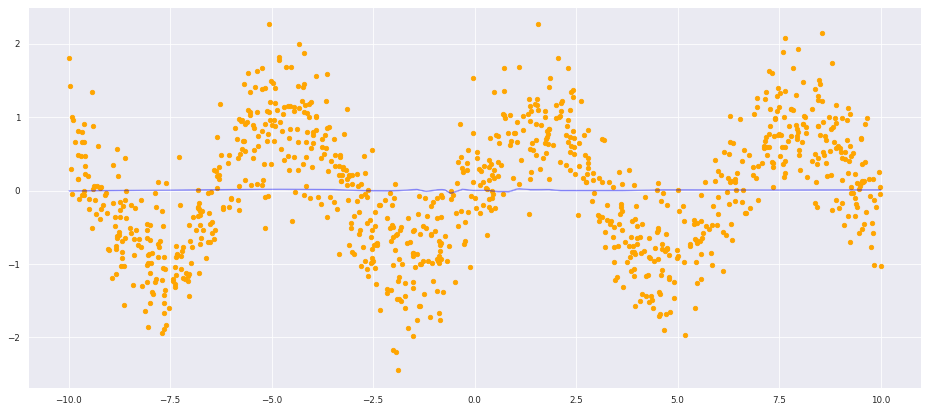

In [16]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="orange", s=20, alpha=1.0)
plt.plot(x_train[train_sort], means, color="blue", alpha=0.3)
for c in range(1, 4):
    plt.fill_between(x_train[train_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

In [17]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

NameError: name 'bnn' is not defined

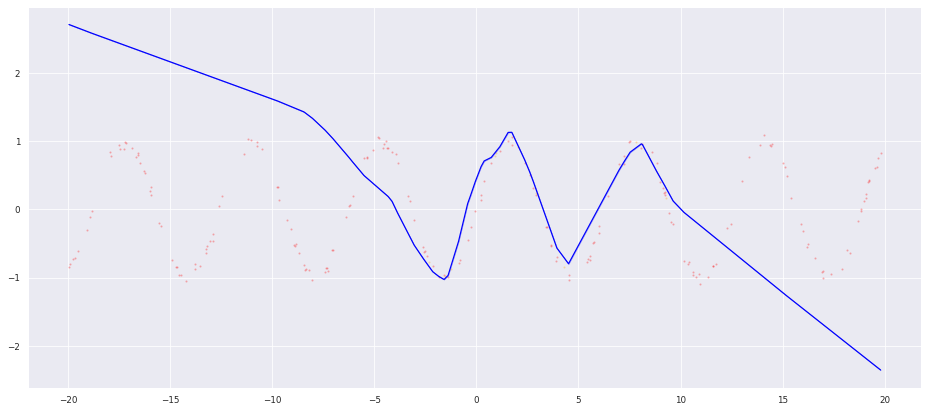

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

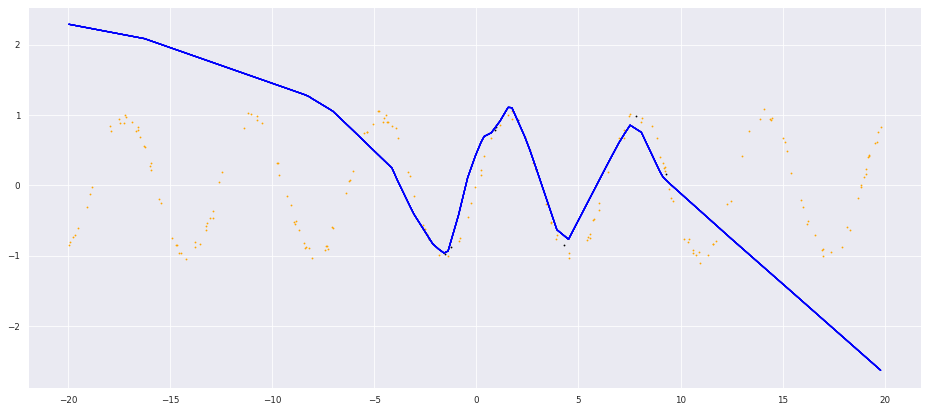

In [ ]:


sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [ ]:
bnn.get_error_metrics(x_train, y_train, num_predictions=100, reduction="mean")

(tensor(0.0034), tensor(-1678.1350), tensor(0.0461))